# 라이브러리 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

import konlpy
from konlpy import tag

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

import sentencepiece as spm

In [2]:
print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


# 세션 초기화

In [8]:
# clear session

# del model

# from keras import backend as K
# K.clear_session()

# import gc
# gc.collect()


8

# 네이버 영화리뷰 

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

# 전처리

## 데이터 불러오기 & 확인

In [16]:
df_train = pd.read_table("./data/ratings_train.txt")
df_test = pd.read_table("./data/ratings_test.txt")

In [17]:
df_train_org = df_train.copy()
df_test_org = df_test.copy()

In [5]:
# df_test = df_test_org.copy()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## 누락 데이터 제거

In [18]:
df_train = df_train.dropna()

In [9]:
df_train[df_train["document"].isna() == True]

,id,document,label


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [19]:
df_test = df_test.dropna()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49997 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49997 non-null  int64 
 1   document  49997 non-null  object
 2   label     49997 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


## 중복 데이터 제거

In [8]:
df_train[df_train["document"].duplicated() == True].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3813 entries, 1058 to 149987
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3813 non-null   int64 
 1   document  3813 non-null   object
 2   label     3813 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 119.2+ KB


In [20]:
df_train = df_train.drop_duplicates(subset=['document'])

In [21]:
df_train[df_train["document"].duplicated() == True].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        0 non-null      int64 
 1   document  0 non-null      object
 2   label     0 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 0.0+ bytes


## 문장 길이 확인 & 조정

In [22]:
df_train['length'] = df_train['document'].str.len()
df_test['length'] = df_test['document'].str.len()

In [12]:
df_train['length'].describe()

count    146182.000000
mean         35.981338
std          29.491233
min           1.000000
25%          16.000000
50%          27.000000
75%          43.000000
max         146.000000
Name: length, dtype: float64

In [13]:
df_test['length'].describe()

count    49997.000000
mean        35.320259
std         29.648310
min          1.000000
25%         16.000000
50%         27.000000
75%         43.000000
max        144.000000
Name: length, dtype: float64

### 문장 길이 1 확인 및 삭제

In [14]:
df_length_1 = df_train[df_train['length'] == 1]

In [15]:
df_length_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 151 to 147788
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        101 non-null    int64 
 1   document  101 non-null    object
 2   label     101 non-null    int64 
 3   length    101 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 3.9+ KB


In [25]:
df_length_1.head(10)

,id,document,label,length
151,7348295,아,0,1
384,7679615,잼,1,1
584,7117896,1,0,1
593,6478189,4,0,1
1723,3412704,굿,1,1
2171,7030708,짱,1,1
2374,7910238,휴,1,1
2968,7957379,.,1,1
3734,304515,음,1,1
3887,6959675,?,1,1


In [23]:
df_train = df_train[df_train['length'] > 1]

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146081 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146081 non-null  int64 
 1   document  146081 non-null  object
 2   label     146081 non-null  int64 
 3   length    146081 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB


<AxesSubplot:>

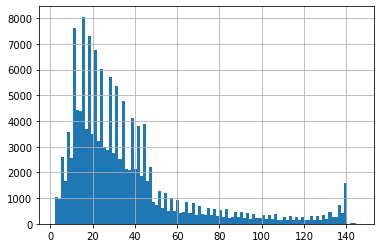

In [18]:
df_train['length'].hist(bins=100)

### 문장길이 60 이하 삭제

In [24]:
df_train = df_train[df_train['length'] < 60]

<AxesSubplot:>

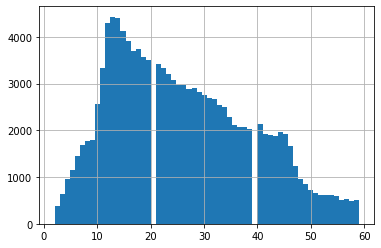

In [25]:
df_train['length'].hist(bins=60)

<AxesSubplot:>

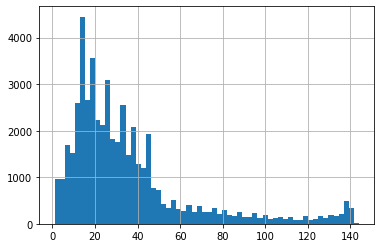

In [21]:
df_test['length'].hist(bins=60)

In [26]:
df_test = df_test[df_test['length'] < 60]

<AxesSubplot:>

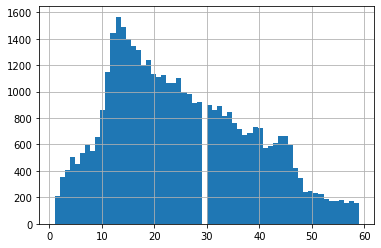

In [27]:
df_test['length'].hist(bins=60)

## 레이블 분포 확인

<AxesSubplot:>

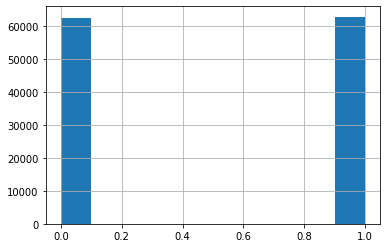

In [24]:
df_train["label"].hist()

# SentencePiece

In [28]:
def get_sp_params(inputs, vocab_size, prefix='spm', model_type='unigram'):

    templates = '--input={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --model_prefix={} \
    --vocab_size={} \
    --character_coverage={} \
    --model_type={}'


    pad_id = 0  #<pad> token을 0으로 설정
    vocab_size = vocab_size # vocab 사이즈
    prefix = prefix # 저장될 tokenizer 모델에 붙는 이름
    bos_id = 1 #<start> token을 1으로 설정
    eos_id = 2 #<end> token을 2으로 설정
    unk_id = 3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    model_type = model_type # Choose from unigram (default), bpe, char, or word


    params = templates.format(inputs,
                           pad_id,
                           bos_id,
                           eos_id,
                           unk_id,
                           prefix,
                           vocab_size,
                           character_coverage,
                           model_type)
    
    return params

In [29]:
def get_sp(prefix, model_type, text_data):

    temp_file = 'data/korean-english-park.train.ko.temp'

    vocab_size = 8000

    print("temp file.")
    with open(temp_file, 'w') as f:
        for row in text_data:
            f.write(str(row) + '\n')

    print("train.")
    spm.SentencePieceTrainer.Train(get_sp_params(temp_file, vocab_size, prefix, model_type))

    s = spm.SentencePieceProcessor()
    s.Load(prefix + '.model')
    
    return s

In [30]:
s = get_sp('spm_0', 'bpe', df_train["document"])

temp file.
train.


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=data/korean-english-park.train.ko.temp     --pad_id=0     --bos_id=1     --eos_id=2     --unk_id=3     --model_prefix=spm_0     --vocab_size=8000     --character_coverage=1.0     --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: spm_0
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard

# 토큰화

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [31]:
def sp_word_index(tokens, prefix):
    with open(f"./{prefix}.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    return word_index, index_word

150755 active=10055 piece=있다
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=480 size=660 all=152157 active=11457 piece=▁긴장감
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=463 size=680 all=153303 active=12603 piece=▁보다가
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=448 size=700 all=154763 active=14063 piece=▁로맨
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=448 min_freq=32
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=433 size=720 all=155659 active=8629 piece=아니
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=425 size=740 all=156605 active=9575 piece=▁신선
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=414 size=760 all=157753 active=10723 piece=▁뭘
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=406 size=780 all=158891 active=11861 piece=▁메
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=399 size=800 all=159858 active=12828 piece=▁아니라
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=398 min_freq=30
bpe_model_trainer.cc(258) LOG(INFO) Added

In [32]:
def sp_tokenize(corpus):

    tokens = []

    for sen in corpus:
        try:
            tokens.append(s.EncodeAsIds(sen))
        except TypeError:
            print(sen)
            
    return tokens

=12801 piece=▁괴물
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=97 size=2680 all=227409 active=13241 piece=한국
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=96 size=2700 all=227740 active=13572 piece=괜찮
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=96 min_freq=16
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=96 size=2720 all=228338 active=11912 piece=▁이거보고
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=95 size=2740 all=228746 active=12320 piece=▁아닌가
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=94 size=2760 all=229252 active=12826 piece=▁건지
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=93 size=2780 all=229748 active=13322 piece=것들
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=93 size=2800 all=230239 active=13813 piece=▁마세요
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=93 min_freq=16
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=92 size=2820 all=230758 active=12030 piece=▁두고
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=91 s

In [33]:
def get_inputs(tokenize, train_data, test_data):
    train_tokens = tokenize(train_data)
    test_tokens = tokenize(test_data)
    
    train_max_length = len(max(train_tokens, key=len))
    test_max_length = len(max(test_tokens, key=len))
    maxlen = train_max_length if train_max_length > test_max_length else test_max_length
    print("maxlen: ", maxlen)
    
    train_tokens = tf.keras.preprocessing.sequence.pad_sequences(train_tokens, padding='post', maxlen=maxlen)
    test_tokens = tf.keras.preprocessing.sequence.pad_sequences(test_tokens, padding='post', maxlen=maxlen)
    
    return train_tokens, test_tokens, maxlen

In [34]:
train_inputs, test_inputs, max_len = get_inputs(sp_tokenize, df_train["document"], df_test["document"])

maxlen:  48


In [35]:
train_labels = np.array(df_train["label"])
test_labels = np.array(df_test["label"])

# 모델

### LSTM

In [36]:
def build_model(vocab_size, input_length, embedding_dim):
    inputs = layers.Input(shape=(input_length,))
    x = layers.Embedding(vocab_size, embedding_dim, 
                         #embeddings_regularizer=regularizers.l2(1e-4),
                         input_length=input_length)(inputs)
    #x = layers.BatchNormalization()(x)
    #x = layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.LSTM(128)(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

### Transformer

In [92]:
def scaled_dot_product_attention(query, key, value):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output

def multi_head_attention(embedding_dim, num_heads, inputs):
    depth = embedding_dim // num_heads
    query = layers.Dense(embedding_dim)(inputs)
    key = layers.Dense(embedding_dim)(inputs)
    value = layers.Dense(embedding_dim)(inputs)
    queries = tf.split(query, num_heads, axis=2)
    keys = tf.split(key, num_heads, axis=2)
    values = tf.split(value, num_heads, axis=2)
    attention = [scaled_dot_product_attention(q, k, v) for q, k, v in zip(queries, keys, values)]
    concat_attention = tf.concat(attention, axis=2)
    output = layers.Dense(embedding_dim)(concat_attention)
    return output

def transformer_encoder_block(embedding_dim, num_heads, ffnn_dim, inputs):
    attention_output = multi_head_attention(embedding_dim, num_heads, inputs)
    attention_output = layers.LayerNormalization()(inputs + attention_output)
    ffnn_output = layers.Dense(ffnn_dim, activation='relu')(attention_output)
    ffnn_output = layers.Dense(embedding_dim)(ffnn_output)
    encoder_output = layers.LayerNormalization()(attention_output + ffnn_output)
    return encoder_output

def build_transformer_model(vocab_size, input_length, embedding_dim, num_blocks=1, num_heads=2, ffnn_dim=128):
    inputs = layers.Input(shape=(input_length,))
    x = layers.Embedding(vocab_size, embedding_dim, input_length=input_length)(inputs)
    pos_encoding = positional_encoding(input_length, embedding_dim)
    x += pos_encoding
    
    for _ in range(num_blocks):
        x = transformer_encoder_block(embedding_dim, num_heads, ffnn_dim, x)
    
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def positional_encoding(position, d_model):
    angles = 1 / tf.pow(10000, (2 * (tf.range(d_model, dtype=tf.float32)[tf.newaxis, :] // 2)) / tf.cast(d_model, tf.float32))
    pos_encoding = tf.range(position, dtype=tf.float32)[:, tf.newaxis] * angles

    # Split even and odd indices
    pos_encoding_sin = tf.math.sin(pos_encoding[:, 0::2])
    pos_encoding_cos = tf.math.cos(pos_encoding[:, 1::2])

    # Concatenate back together
    pos_encoding = tf.concat([pos_encoding_sin, pos_encoding_cos], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return pos_encoding


### 모델 생성

In [37]:
def train_model(input_length, embedding_dim, 
                train_inputs, train_labels,
                test_inputs, test_labels,
                model_name, model_desc,
                build_model, vocab_size=8000):
    
    cb_es = callbacks.EarlyStopping(
        monitor='val_loss', mode='min', verbose=1, patience=5)
    
    cb_mc = callbacks.ModelCheckpoint(
        model_name + '.h5', monitor='val_accuracy', 
        mode='max', verbose=1, save_best_only=True)
    
    model = build_model(
        vocab_size=vocab_size,
        input_length=input_length, 
        embedding_dim=embedding_dim)
    
    history = model.fit(
        train_inputs, train_labels, 
        epochs=20, batch_size=256, 
        callbacks=[cb_es, cb_mc],
        validation_split=0.2)
    
    result = model.evaluate(test_inputs, test_labels)
    print(result)
    
    history_result = {
        "name": model_name,
        "history": history,
        "evaluation": result,
        "description": model_desc,
    }
    
    return model, history_result

In [38]:
histories = []

# 모델 학습

### LSTM

In [61]:
embedding_dim = 128
model_name = "sp_bpe_emb128_lstm128"
model_desc = "SentencePiece_BPE, embedding 128, LSTM 128"

model, history_result = train_model(max_len, embedding_dim,
                                    train_inputs, train_labels,
                                    test_inputs, test_labels,
                                    model_name, model_desc,
                                    build_model)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 48, 128)           1024000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,155,713
Trainable params: 1,155,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 5s 9ms/step - loss: 0.5729 - accuracy: 0.6470 - val_loss: 0.3889 - val_accuracy: 0.8314

Epoch 00001: val_accuracy improved from -inf to 0.83145, saving model to sp_bpe_emb128_lstm128.h5
Epoch 

### Transformer

In [93]:
embedding_dim = 128
model_name = "sp_bpe_emb128_transformer_h2d128"
model_desc = "SentencePiece_BPE, embedding 128, Transformer - head 2, dim 128"

model, history_result = train_model(max_len, embedding_dim,
                                    train_inputs, train_labels,
                                    test_inputs, test_labels,
                                    model_name, model_desc,
                                    build_transformer_model)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 48, 128)      1024000     input_8[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_3 (TFOpLam (None, 48, 128)      0           embedding_7[0][0]                
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 48, 128)      16512       tf.__operators__.add_3[0][0]     
____________________________________________________________________________________________

In [94]:
histories.append(history_result)

# KoNLPy 비교

## Mecab

In [39]:
mecab = tag.Mecab()

In [40]:
df_train['mecab'] = df_train['document'].apply(mecab.morphs)
df_test['mecab'] = df_test['document'].apply(mecab.morphs)

df_train.head()

,id,document,label,length,mecab
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19,"[아, 더, 빙, ., ., 진짜, 짜증, 나, 네요, 목소리]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33,"[흠, ., .., 포스터, 보고, 초딩, 영화, 줄, ., ..., 오버, 연기,..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,17,"[너무, 재, 밓었다그래서보는것을추천한다]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29,"[교도소, 이야기, 구먼, ., ., 솔직히, 재미, 는, 없, 다, ., ., 평..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0,45,"[막, 걸음마, 뗀, 3, 세, 부터, 초등, 학교, 1, 학년, 생, 인, 8, ..."


In [41]:
tokenizer_mecab = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer_mecab.fit_on_texts(df_train["mecab"])

In [42]:
train_inputs_mecab, test_inputs_mecab, max_len = get_inputs(tokenizer_mecab.texts_to_sequences,
                                                   df_train["mecab"], df_test["mecab"])

maxlen:  48


In [43]:
train_labels_mecab = np.array(df_train["label"])
test_labels_mecab = np.array(df_test["label"])

In [46]:
embedding_dim = 128
model_name = "mecab_emb128"
model_desc = "Mecab, embedding 128, LSTM 128, Dense 64"

model, history_result = train_model(max_len, embedding_dim,
                                    train_inputs_mecab, train_labels,
                                    test_inputs_mecab, test_labels,
                                    model_name, model_desc,
                                    build_model)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 48, 128)           1024000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,163,905
Trainable params: 1,163,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 5s 9ms/step - loss: 0.4839 - accuracy: 0.7341 - val_loss: 0.3

In [47]:
histories.append(history_result)

## Komoran

In [48]:
kmr = tag.Komoran()

In [49]:
df_train['komoran'] = df_train['document'].apply(kmr.morphs)
df_test['komoran'] = df_test['document'].apply(kmr.morphs)

df_train.head()

,id,document,label,length,mecab,komoran
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19,"[아, 더, 빙, ., ., 진짜, 짜증, 나, 네요, 목소리]","[아, 더빙, ., ., 진짜, 짜증, 나, 네요, 목소리]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33,"[흠, ., .., 포스터, 보고, 초딩, 영화, 줄, ., ..., 오버, 연기,...","[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,17,"[너무, 재, 밓었다그래서보는것을추천한다]",[너무재밓었다그래서보는것을추천한다]
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29,"[교도소, 이야기, 구먼, ., ., 솔직히, 재미, 는, 없, 다, ., ., 평...","[교도소, 이야기, 이, 구먼, .., 솔직히, 재미, 는, 없, 다, ., ., ..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0,45,"[막, 걸음마, 뗀, 3, 세, 부터, 초등, 학교, 1, 학년, 생, 인, 8, ...","[막, 걸음마, 떼, ㄴ, 3, 세, 부터, 초등학교, 1, 학년, 생, 이, ㄴ,..."


In [50]:
train_inputs_kmr, test_inputs_kmr, max_len = get_inputs(tokenizer_mecab.texts_to_sequences,
                                                   df_train["komoran"], df_test["komoran"])

maxlen:  57


In [51]:
embedding_dim = 128
model_name = "kmr_emb128"
model_desc = "Komoran, embedding 128, LSTM 128, Dense 64"

model, history_result = train_model(max_len, embedding_dim,
                                    train_inputs_kmr, train_labels,
                                    test_inputs_kmr, test_labels,
                                    model_name, model_desc,
                                    build_model)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 57, 128)           1024000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,163,905
Trainable params: 1,163,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 8s 12ms/step - loss: 0.6934 - accuracy: 0.4981 - val_loss: 0.

In [52]:
histories.append(history_result)

# Word2Vec

In [53]:
w2v = Word2Vec(sentences = df_train["mecab"],
               vector_size = 100,
               window = 5,
               min_count = 5,
               workers = 4,
               sg = 0)

In [273]:
w2v.wv.vectors.shape

(11755, 100)

In [54]:
embedding_matrix = np.zeros((len(tokenizer_mecab.word_index) + 1, w2v.vector_size))
for word, i in tokenizer_mecab.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]

In [303]:
embedding_matrix.shape

(42462, 100)

In [55]:
def build_model_w2v(vocab_size, input_length, embedding_dim):
    print(vocab_size, input_length, embedding_dim)
    inputs = layers.Input(shape=(input_length,))
    x = layers.Embedding(
        vocab_size,
        embedding_dim,
        input_length=input_length,
        weights=[embedding_matrix],
        trainable=True)(inputs)
    x = layers.LSTM(128)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [61]:
embedding_dim = w2v.vector_size
model_name = "w2v_emb128_patience5"
model_desc = "Mecab, Word2Vec, embedding 128, LSTM 128, Patience 5"
vocab_size = len(tokenizer_mecab.word_index) + 1
max_len = test_inputs_mecab.shape[1]

model, history_result = train_model(max_len, embedding_dim,
                                    train_inputs_mecab, train_labels,
                                    test_inputs_mecab, test_labels,
                                    model_name, model_desc,
                                    build_model_w2v,
                                    vocab_size=vocab_size)

42462 48 100
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 48, 100)           4246200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 4,363,577
Trainable params: 4,363,577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 8s 12ms/step - loss: 0.4097 - accuracy: 0.8130 - val_loss: 0.3649 - val_accuracy: 0.8369

Epoch 00001: val_accuracy improved from -inf to 0.83693, saving model to w2v_emb128_patien

In [62]:
histories.append(history_result)

# FastText

In [ ]:
import datetime

print(f"== LOAD fasttext START at {datetime.datetime.now()}")
ftk = gensim.models.fasttext.load_facebook_model('data/cc.ko.300.bin')
print(f"== LOAD fasttext   END at {datetime.datetime.now()}")

RAM 용량 초과로 로딩 실패

In [7]:
with open("./data/cc.ko.300.vec", "r") as f:
    word_size, vector_size = f.readline().split(" ")
    print(f"word_size  : {word_size:7s}")
    print(f"vector_size: {vector_size.strip():7s}")
    print("==" * 20)
    for i in range(0, 10):
        line = str(f.readline())
        ws = line.split(" ")
        kwd, kwd_vec = ws[0], ws[1:]
        print(f"{kwd:7s} :: {kwd_vec[:5]}")

word_size  : 2000000
vector_size: 300    
.       :: ['-0.0219', '0.0241', '0.2438', '0.0407', '0.0262']
,       :: ['0.0183', '-0.1265', '-0.0139', '-0.0290', '-0.0255']
</s>    :: ['-0.0838', '-0.0291', '0.0596', '0.0081', '0.0171']
)       :: ['0.0258', '-0.0274', '0.0148', '-0.0125', '-0.0405']
(       :: ['0.0255', '-0.0435', '-0.1910', '0.0077', '-0.0553']
:       :: ['-0.0398', '0.0695', '0.0309', '0.0748', '0.0798']
'       :: ['-0.0145', '-0.0033', '-0.0909', '-0.0266', '0.0203']
"       :: ['-0.0087', '0.0310', '0.0439', '-0.0519', '-0.0093']
/       :: ['-0.0416', '0.0256', '-0.0860', '0.0397', '0.2192']
수       :: ['-0.1575', '0.1748', '0.2228', '-0.0091', '0.0245']


In [10]:
ftk = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('data/cc.ko.300.vec', limit=10000)

In [15]:
ftk.vector_size

300

In [71]:
test_sentence = df_train["mecab"][3]
print(test_sentence)
for w in test_sentence:
    print(ftk.key_to_index[w], end=" ") if w in ftk.key_to_index else print("()", end=" ")

['교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '는', '없', '다', '.', '.', '평점', '조정']
() 863 () 0 0 5086 () 32 () 238 0 0 7233 5025 

In [55]:
embedding_matrix = np.zeros((len(tokenizer_mecab.word_index) + 1, ftk.vector_size))
for word, i in tokenizer_mecab.word_index.items():
    if word in ftk.key_to_index:
        embedding_matrix[i] = ftk.get_vector(ftk.key_to_index[word])

In [56]:
embedding_matrix.shape

(42462, 300)

In [57]:
def build_model_ftk(vocab_size, input_length, embedding_dim):
    print(vocab_size, input_length, embedding_dim)
    inputs = layers.Input(shape=(input_length,))
    x = layers.Embedding(
        vocab_size,
        embedding_dim,
        input_length=input_length,
        weights=[embedding_matrix],
        trainable=True)(inputs)
    x = layers.LSTM(128)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [58]:
embedding_dim = ftk.vector_size
model_name = "ftk_emb128_patience5"
model_desc = "Mecab, FastText, embedding 128, LSTM 128, Patience 5"
vocab_size = len(tokenizer_mecab.word_index) + 1
max_len = test_inputs_mecab.shape[1]

model, history_result = train_model(max_len, embedding_dim,
                                    train_inputs_mecab, train_labels,
                                    test_inputs_mecab, test_labels,
                                    model_name, model_desc,
                                    build_model_ftk,
                                    vocab_size=vocab_size)

42462 48 300
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 48, 300)           12738600  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 12,958,377
Trainable params: 12,958,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 35s 16ms/step - loss: 0.4165 - accuracy: 0.8034 - val_loss: 0.3477 - val_accuracy: 0.8497

Epoch 00001: val_accuracy improved from -inf to 0.84968, saving model to ftk_emb128_patie

In [59]:
histories.append(history_result)

# 시각화

In [81]:
len(histories)

9

In [152]:
for i, item in enumerate(histories):
    print(f"{i:2}: {item['name']} \n\t{item['description']}\n")

 0: sp_bpe_emb128_dense64 
	SentencePiece_BPE, embedding 128, dense 64

 1: mecab_emb128 
	Mecab, embedding 128, LSTM 128, Dense 64

 2: kmr_emb128 
	Komoran, embedding 128, LSTM 128, Dense 64

 3: w2v_emb128 
	Mecab, Word2Vec, embedding 128, LSTM 128

 4: w2v_emb128_patience5 
	Mecab, Word2Vec, embedding 128, LSTM 128, Patience 5

 5: sp_bpe_emb128_lstm128 
	SentencePiece_BPE, embedding 128, LSTM 128

 6: sp_bpe_emb128_lstm128_dropout2 
	SentencePiece_BPE, embedding 128, LSTM 128, Dropout 0.2

 7: sp_bpe_emb128_lstm128_dropout1 
	SentencePiece_BPE, embedding 128, LSTM 128, Dropout 0.1

 8: sp_bpe_emb128_lstm64 
	SentencePiece_BPE, embedding 128, LSTM 64

 9: sp_bpe_emb128_lstm128_dense64_bn_l2 
	SentencePiece_BPE, embedding 128, LSTM 128, Dense 64, BatchNormalization, L2

10: sp_bpe_emb128_lstm128_dense64_bn_l2_nodrop 
	SentencePiece_BPE, embedding 128, LSTM 128, Dense 64, BatchNormalization, L2, Dropout X

11: sp_bpe_emb128_lstm128_dense64_bn 
	SentencePiece_BPE, embedding 128, LSTM 

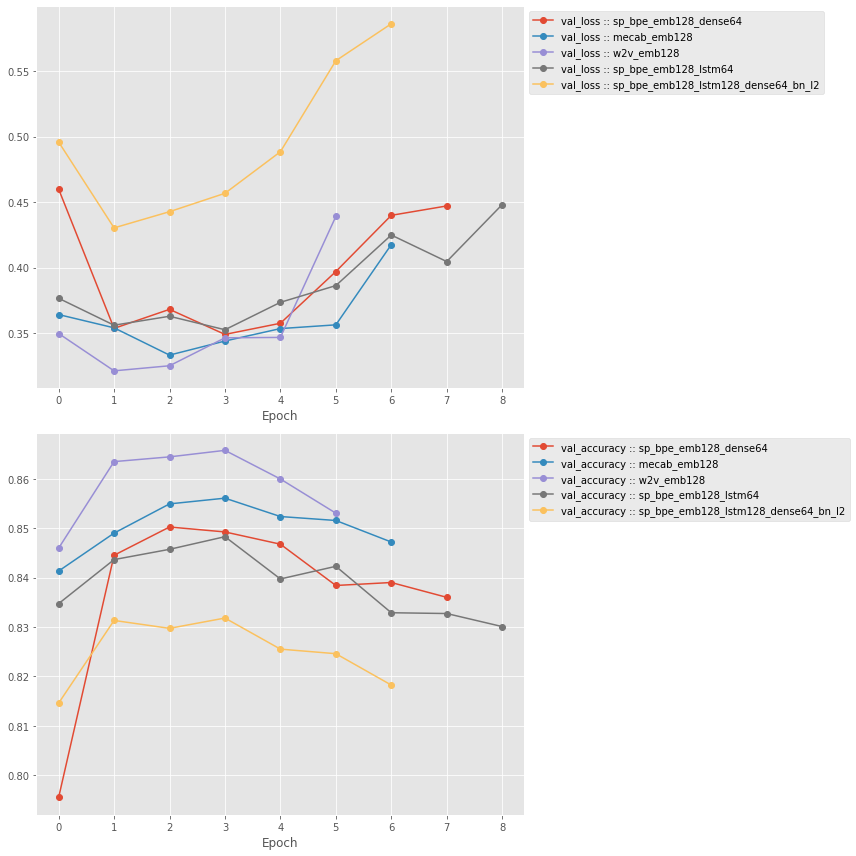

In [154]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')

# Define subplots upfront
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

# Define metrics and their corresponding subplots
metrics_axes = [
    ('loss', 'val_loss', ax1),
    ('accuracy', 'val_accuracy', ax2)
]

history_selection = [0, 1, 3, 8, 9]

for i in history_selection:
    history = histories[i]["history"]

    color = next(ax1._get_lines.prop_cycler)['color']

    for metric, val_metric, ax in metrics_axes:
#         ax.plot(history.history[metric], 
#                 linestyle='--', marker='x', color=color, 
#                 label=f"{metric} :: {histories[i]['name']}")
        ax.plot(history.history[val_metric], 
                linestyle='-', marker='o', color=color, 
                label=f"{val_metric} :: {histories[i]['name']}")
        ax.set_xlabel('Epoch')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


SentencePiece VS. KoNLPy 등 다른 모델들과 비교
- SentencePiece 기본값인 unigram 보다 bpe 가 조금 나은 결과를 보여주었다.
- KoNLPy Mecab 형태소 분석기를 쓴 모델이 SentencePiece 모델 보다 조금 더 나은 결과가 나왔다.
- Mecab 을 쓴 데이터로 Word2Vector 를 거친 모델이 제일 좋은 결과를 보여주었다.
- LSTM 128에서 64로 줄여보니 결과는 더 안좋아진다.

과적합 
- 전체적으로 과적합 양상이 보인다. 
- Dropout 레이어를 0.1, 0.2 값으로 추가해봤는데, 전혀 학습이 되지 않았다.
- L2, BatchNormalization, Dropout 추가: 학습은 되는데, 성능이 좋지 않다.
- L2, BatchNormalization, Dropout 넣고 빼고 해본 결과 다 빼는 것이 제일 낫다.
- SentencePiece 결과중에서는 단순하게 LSTM 128 레이어 하나만 가진 모델이 제일 좋은 결과를 보여주었다.

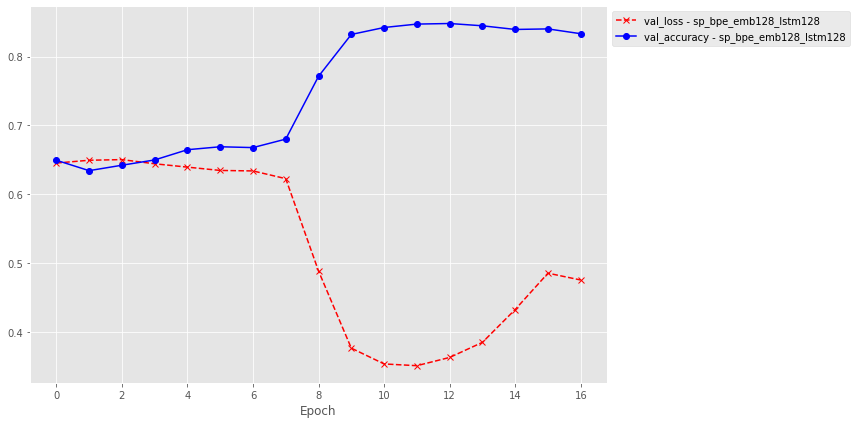

In [164]:
plt.figure(figsize=(12, 6))
plt.plot(histories[16]["history"].history["val_loss"],
        linestyle='--', marker='x', color='r', 
        label=f"val_loss - {histories[16]['name']}")
plt.plot(histories[16]["history"].history["val_accuracy"],
        linestyle='-', marker='o', color='b', 
        label=f"val_accuracy - {histories[16]['name']}")
plt.xlabel('Epoch')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## 추가 시도 - FastText, Transformer

In [95]:
for i, item in enumerate(histories):
    print(f"{i:2}: {item['name']} \n\t{item['description']}\n")

 0: ftk_emb128_patience5 
	Mecab, FastText, embedding 128, LSTM 128, Patience 5

 1: sp_bpe_emb128_lstm128 
	SentencePiece_BPE, embedding 128, LSTM 128

 2: sp_bpe_emb128_transformer 
	SentencePiece_BPE, embedding 128, Transformer

 3: sp_bpe_emb128_transformer 
	SentencePiece_BPE, embedding 128, Transformer

 4: sp_bpe_emb128_transformer_h2d128 
	SentencePiece_BPE, embedding 128, Transformer - head 2, dim 128



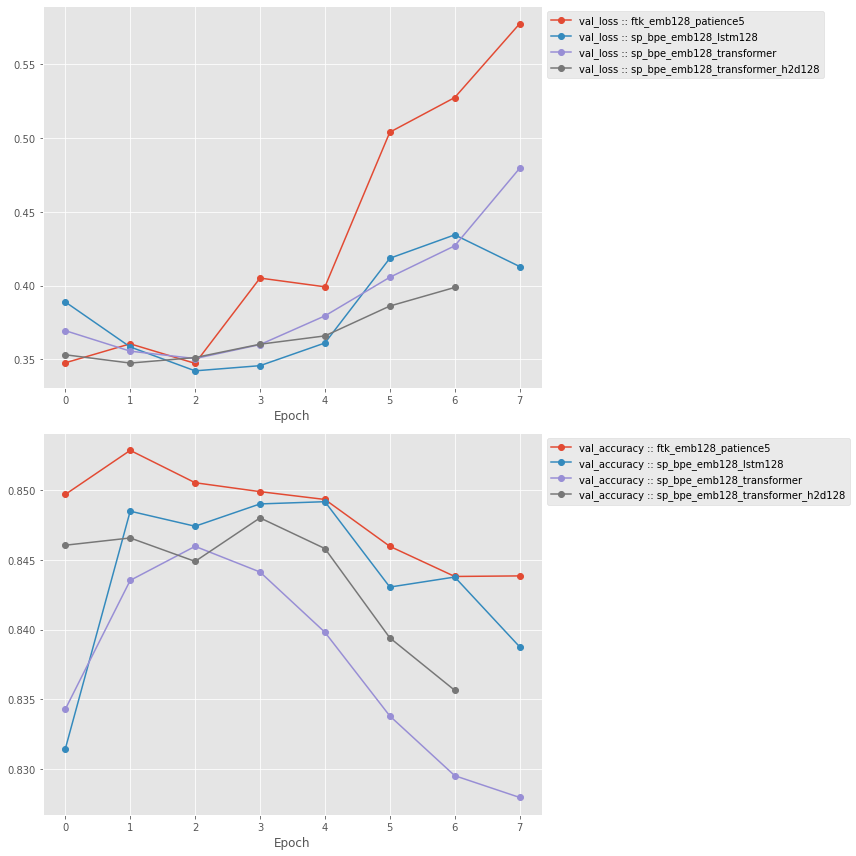

In [96]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')

# Define subplots upfront
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

# Define metrics and their corresponding subplots
metrics_axes = [
    ('loss', 'val_loss', ax1),
    ('accuracy', 'val_accuracy', ax2)
]

history_selection = [0, 1, 3, 4]

for i in history_selection:
    history = histories[i]["history"]

    color = next(ax1._get_lines.prop_cycler)['color']

    for metric, val_metric, ax in metrics_axes:
#         ax.plot(history.history[metric], 
#                 linestyle='--', marker='x', color=color, 
#                 label=f"{metric} :: {histories[i]['name']}")
        ax.plot(history.history[val_metric], 
                linestyle='-', marker='o', color=color, 
                label=f"{val_metric} :: {histories[i]['name']}")
        ax.set_xlabel('Epoch')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()